# SNRcat vs. Green's SNR catalog

This is a quick check on SNR positions and extensions from:

* SNRcat ([webpage](http://www.physics.umanitoba.ca/snr/SNRcat/))
* Green's SNR catalog
  ([webpage](https://www.mrao.cam.ac.uk/surveys/snrs/),
  [vizier](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=VII/272))

## Summary

* They are (by now, after some iteration) mostly consistent. 
* For the few remaining differences SNRcat has the better values.
* The more important point is that SNRcat is more up to date, i.e. has more SNRs.

**Use SNRcat!**

## Some setup

We can get the Green and SNRcat as an Astropy table via [gammapy.datasets](https://gammapy.readthedocs.org/en/latest/datasets/index.html):

* [gammapy.datasets.load_catalog_green](https://gammapy.readthedocs.org/en/latest/api/gammapy.datasets.load_catalog_green.html)
* [gammapy.datasets.fetch_catalog_snrcat](https://gammapy.readthedocs.org/en/latest/api/gammapy.datasets.fetch_catalog_snrcat.html)

In [1]:
%matplotlib inline
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from gammapy.datasets import load_catalog_green, fetch_catalog_snrcat

In [2]:
green = load_catalog_green()
print(green.colnames)
# green.show_in_browser(jsviewer=True)

['Source_Name', 'RAJ2000', 'DEJ2000', 'GLON', 'GLAT', 'Dmean', 'Dmaj', 'Dmin', 'u_Dmin', 'l_S_1GHz_', 'S_1GHz_', 'u_S_1GHz_', 'alpha', 'u_alpha', 'type', 'Names']


In [3]:
snrcat = fetch_catalog_snrcat().snr_table
print('Download date:', snrcat.meta['version'])
print(snrcat.colnames)
# snrcat.show_in_browser(jsviewer=True)
# pprint(snrcat.dtype)

Download date: 2015-06-07
['Source_Name', 'id_uncertain', 'id_alt', 'id_old', 'type', 'type_uncertain', 'context', 'remnant', 'SN_year', 'SN_association', 'age_min', 'age_max', 'age', 'distance_min', 'distance_max', 'distance', 'diameter_mean', 'diameter_mean_is_imprecise', 'diameter_radio_str', 'diameter_radio_mean', 'diameter_xray_str', 'diameter_xray_mean', 'RAJ2000_str', 'RAJ2000', 'DEJ2000_str', 'DEJ2000', 'J2000_from', 'GLON', 'GLAT']


In [4]:
def save_snrcat_to_fits():
    """Save catalogs to FITS files e.g. for browsing with TOPCAT"""
    snrcat = fetch_catalog_snrcat()
    snrcat.snr_table.write('green_snrcat_check_snrcat_snr.fits', overwrite=True)
    snrcat.obs_table.write('green_snrcat_check_snrcat_obs.fits', overwrite=True)

# save_snrcat_to_fits()

## Is Green a subset of SNRcat?

Yes it is, all OK.

In [5]:
print(len(green))

294


In [6]:
print(len(snrcat))

378


In [7]:
set(green['Source_Name']).issubset(snrcat['Source_Name'])

True

## Join catalogs

In order to be able to do checks we need to join the two catalogs.

We do an inner join, i.e. the output table will only contain the SNRs that are in both catalogs.

In [8]:
from astropy.table import join as table_join
def tag_colnames(table, label):
    table = table.copy()
    for colname in table.colnames[1:]:
        table.rename_column(colname, label + '_' + colname)
    return table

cat = table_join(tag_colnames(green, 'Green'),
                 tag_colnames(snrcat, 'SNRcat')
                )
print(len(cat))
print(cat.colnames)

294
['Source_Name', 'Green_RAJ2000', 'Green_DEJ2000', 'Green_GLON', 'Green_GLAT', 'Green_Dmean', 'Green_Dmaj', 'Green_Dmin', 'Green_u_Dmin', 'Green_l_S_1GHz_', 'Green_S_1GHz_', 'Green_u_S_1GHz_', 'Green_alpha', 'Green_u_alpha', 'Green_type', 'Green_Names', 'SNRcat_id_uncertain', 'SNRcat_id_alt', 'SNRcat_id_old', 'SNRcat_type', 'SNRcat_type_uncertain', 'SNRcat_context', 'SNRcat_remnant', 'SNRcat_SN_year', 'SNRcat_SN_association', 'SNRcat_age_min', 'SNRcat_age_max', 'SNRcat_age', 'SNRcat_distance_min', 'SNRcat_distance_max', 'SNRcat_distance', 'SNRcat_diameter_mean', 'SNRcat_diameter_mean_is_imprecise', 'SNRcat_diameter_radio_str', 'SNRcat_diameter_radio_mean', 'SNRcat_diameter_xray_str', 'SNRcat_diameter_xray_mean', 'SNRcat_RAJ2000_str', 'SNRcat_RAJ2000', 'SNRcat_DEJ2000_str', 'SNRcat_DEJ2000', 'SNRcat_J2000_from', 'SNRcat_GLON', 'SNRcat_GLAT']


## Position check

When starting this check there were several inconsistencies, by now most positions are consistent. Remaining differences are due to errors in Green's catalog (for G308.4-01.4, G113.0+00.2, G350.1-0.3, and G358.1+00.1, will be fixed in the next iteration of that catalog) and some refinements done in SNRcat, which we recommend to use.

In [9]:
from astropy.coordinates import SkyCoord
pos_green = SkyCoord(cat['Green_RAJ2000'], cat['Green_DEJ2000'], unit='deg', frame='icrs')
pos_snrcat = SkyCoord(cat['SNRcat_RAJ2000'], cat['SNRcat_DEJ2000'], unit='deg', frame='icrs')
cat['separation'] = pos_green.separation(pos_snrcat)
cat.sort('separation')
cat[-15:][['Source_Name', 'separation', 'Green_RAJ2000', 'SNRcat_RAJ2000',
           'Green_DEJ2000', 'SNRcat_DEJ2000']]

Source_Name,separation,Green_RAJ2000,SNRcat_RAJ2000,Green_DEJ2000,SNRcat_DEJ2000
,deg,deg,deg,deg,deg
str352,float64,float64,float64,float64,float64
G033.2-00.6,4.71404480749e-05,283.4583,283.458333333,-0.0333,-0.0333333333333
G025.1-02.3,0.00650373279507,281.2917,281.2875,-8.0,-7.995
G004.5+06.8,0.00750178892227,262.675,262.670833333,-21.4833,-21.4897222222
G011.2-00.3,0.0104656920823,272.8625,272.870833333,-19.4167,-19.4236111111
G296.7-00.9,0.0145336683286,178.875,178.879166667,-63.1333,-63.1188888889
G021.5-00.9,0.0152492535104,278.3875,278.391666667,-10.5833,-10.5686111111
G111.7-02.1,0.0172120790685,350.8583,350.85,58.8,58.8166666667
G033.6+00.1,0.0390994934749,283.2,283.1625,0.6833,0.672222222222


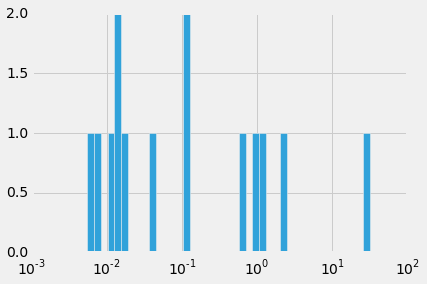

In [10]:
plt.hist(cat['separation'], bins=np.logspace(-3, 1.5, 50));
plt.semilogx();

## Extension check

For HGPS we currently plan to represent radio SNRs as circles for association and on sky images, probably with diameter = geometric mean of major and minor diameter in case of elongated SNRs.

Here's a check comparing these mean SNR diameters from Green against SNRcat.

Most extensions are consistent.

There's four SNRs where the relative size difference is more than 5%
(table shows mean diameters in arcmin):

SNR         | Green | SNRcat 
------------|-------|-------
G054.1+00.3 | 12    | 8
G065.7+01.2 | 22    | 15    
G296.7-00.9 | 10.9  | 12
G308.4-01.4 | 8.5   | 9


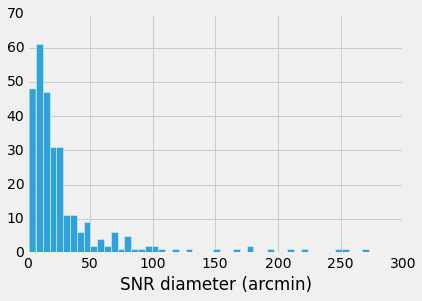

In [11]:
plt.hist(cat['Green_Dmean'], bins=50);
plt.xlabel('SNR diameter (arcmin)');

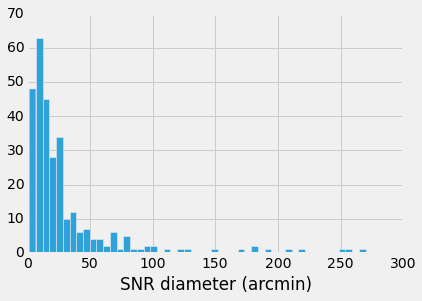

In [12]:
plt.hist(cat['SNRcat_diameter_mean'], bins=50);
plt.xlabel('SNR diameter (arcmin)');

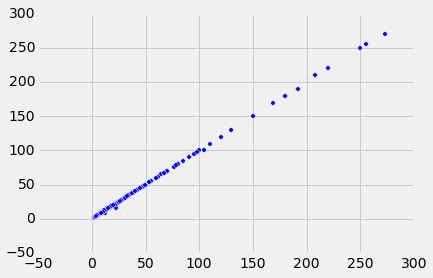

In [13]:
plt.scatter(cat['Green_Dmean'], cat['SNRcat_diameter_mean']);

In [14]:
# Compute absolute and relative difference in diameter
cat['diameter_diff_abs'] = np.abs(cat['Green_Dmean'] - cat['SNRcat_diameter_mean'])
cat['diameter_diff_rel'] = 100. * (cat['diameter_diff_abs'] / cat['Green_Dmean'])

(0.1, 1000.0)

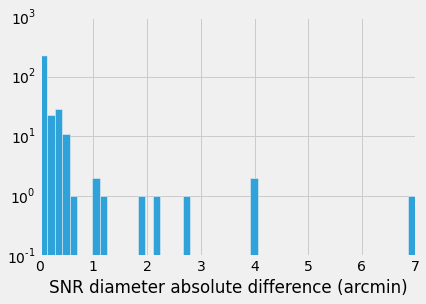

In [15]:
plt.hist(cat['diameter_diff_abs'], bins=50, log=True);
plt.xlabel('SNR diameter absolute difference (arcmin)')
plt.ylim(1e-1, 1e3)

In [16]:
cat.sort('diameter_diff_abs')
cat[-10:][['Source_Name', 'diameter_diff_abs', 'diameter_diff_rel', 'Green_Dmean', 'SNRcat_diameter_mean',
           'SNRcat_diameter_radio_str', 'Green_Dmaj', 'Green_Dmin']]

Source_Name,diameter_diff_abs,diameter_diff_rel,Green_Dmean,SNRcat_diameter_mean,SNRcat_diameter_radio_str,Green_Dmaj,Green_Dmin
,arcmin,arcmin,arcmin,arcmin,,arcmin,arcmin
str352,float64,float64,float32,float64,str544,float32,float32
G082.2+05.3,0.581169128418,0.739578113769,78.5812,78.0,95'x65',95.0,65.0
G025.1-02.3,1.01020431519,2.06207088857,48.9898,50.0,80'x30',80.0,30.0
G296.7-00.9,1.04554843903,9.54450739233,10.9545,12.0,14'x10',15.0,8.0
G315.1+02.7,1.18057250977,0.699310812338,168.819,170.0,190'x150',190.0,150.0
G074.0-08.5,1.83326721191,0.955656564974,191.833,190.0,230'x160',230.0,160.0
G159.6+07.3,2.15390014648,1.03629567647,207.846,210.0,4 deg x 3 deg,240.0,180.0
G065.3+05.7,2.76364135742,1.0132000525,272.764,270.0,310'x240',310.0,240.0
G089.0+04.7,3.92304992676,3.7749564986,103.923,100.0,2 deg x 1.5 deg,120.0,90.0


(0.1, 1000.0)

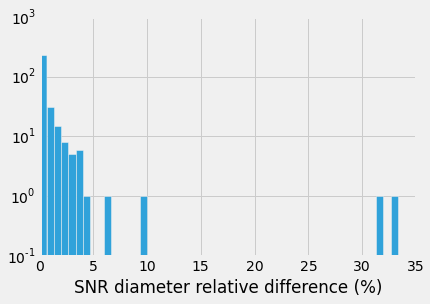

In [17]:
plt.hist(cat['diameter_diff_rel'], bins=50, log=True);
plt.xlabel('SNR diameter relative difference (%)')
plt.ylim(1e-1, 1e3)

In [18]:
cat.sort('diameter_diff_rel')
cat[-10:][['Source_Name', 'diameter_diff_abs', 'diameter_diff_rel', 'Green_Dmean', 'SNRcat_diameter_mean',
           'SNRcat_diameter_radio_str', 'Green_Dmaj', 'Green_Dmin']]

Source_Name,diameter_diff_abs,diameter_diff_rel,Green_Dmean,SNRcat_diameter_mean,SNRcat_diameter_radio_str,Green_Dmaj,Green_Dmin
,arcmin,arcmin,arcmin,arcmin,,arcmin,arcmin
str352,float64,float64,float32,float64,str544,float32,float32
G298.6-00.0,0.392304420471,3.77495120041,10.3923,10.0,12'x9',12.0,9.0
G342.0-00.2,0.392304420471,3.77495120041,10.3923,10.0,12'x9',12.0,9.0
G351.9-00.9,0.392304420471,3.77495120041,10.3923,10.0,12'x9',12.0,9.0
G089.0+04.7,3.92304992676,3.7749564986,103.923,100.0,2 deg x 1.5 deg,120.0,90.0
G286.5-01.2,0.489995956421,3.92310740636,12.49,12.0,26'x6',26.0,6.0
G359.1+00.9,0.51087474823,4.44659394893,11.4891,12.0,12'x11',12.0,11.0
G308.4-01.4,0.514719009399,6.06602197346,8.48528,9.0,14'x6',12.0,6.0
G296.7-00.9,1.04554843903,9.54450739233,10.9545,12.0,14'x10',15.0,8.0
